# Solving Sod Problem with PINN-WE


* This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

* The paper about this code can be reffed to https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

* For strong shock waves, PINN-WE can let you get a discontinuous result quickly and sharply. But it can not guarantee the result must be physical. You can try to change the random seed or learning rate to get a different result. In the paper, we show the best result of some tests to demonstrate that PINN-WE has the potential ability to handle a non-linear discontinuous problem.

* So physics constraints are needed near shock waves. They are conservation laws, Rankine-Hugoniot relations and entropy condition. We develop a physics screen method here to determinate the problem.


In [ ]:
from PINNs import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
dtype=torch.float64
setup_seed(6)
num_ic = 10000                                           
num_int = 500000                                            
Time =  2.0
L = 1.0

In [1]:
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int,x_screen2_L,x_screen2_R,0.01)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        #loss_rh1 = model.loss_rh(x_screen2,x_screen2_L,x_screen2_R) # RH relation
        #loss_s0 = model.loss_character(x_screen2,x_screen2_R) # Entropy condition
        #loss_con3 = model.loss_con(x_screen3 ,x_ic,T3) #Conservation laws
        #loss_con1 = model.loss_con(x_screen1 ,x_ic,T1) #Conservation laws
        loss = loss_pde + 10*(loss_ic)# +loss_bc) +  10*(loss_rh1)  +10* loss_s0 +10*loss_con3   +10* loss_s0  
        #print(f'epoch {epoch} loss_pde:{loss_pde:.8f},loss_rh1:{loss_rh1:.8f},loss_con:{loss_con1:.8f}, loss_s:{loss_s0:.8f}, loss_ic:{loss_ic:.8f}')
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f},loss_rh1:{loss_rh1:.8f},loss_con:{loss_con1:.8f}, loss_s:{loss_s0:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    return loss

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
dtype=torch.float32
dtype=torch.float64
# Seeds
crhoL = 1
cuL = -2
cpL = 0.4

crhoR =1
cuR = 2
cpR = 0.4
Ts = 0
Te = 0.1
rhoref = 1
uref = 1
pref = 1
#crhoL,cuL,cpL,crhoR,cuR,cpR,Te,rhoref,uref,pref = Unit_var(crhoL,cuL,cpL,crhoR,cuR,cpR,Te)

###Ts = 0, Xs =0, Xe = 1

#crhoL = 0.89
#cuL = 0.098923
#cpL = 1
#
#crhoR = 1
#cuR = 0
#cpR = 0.16185
#
#Ts = 0
#Te = 0.91728

Xs = 0
Xe = 1
   
def X_entropy(x,T,dt,dx):
    N=x.shape[0]
    xs   = np.zeros((N,2)) 
    xsL  = np.zeros((N,2)) 
    xsR  = np.zeros((N,2)) 
    xsP  = np.zeros((N,2)) 
    xsPL = np.zeros((N,2)) 
    xsPR = np.zeros((N,2)) 
    
    for i in range(N):
        xs[i,1] = x[i,1]
        xs[i,0] = x[i,0] + T
        xsL[i,1] = xs[i,1] - dx
        xsL[i,0] = xs[i,0]
        xsR[i,1] = xs[i,1] + dx
        xsR[i,0] = xs[i,0]
        xsP[i,0] = xs[i,0] + dt
        xsP[i,1] = xs[i,1]
        xsPL[i,0] = xsP[i,0]
        xsPL[i,1] = xsP[i,1]+ dx
        xsPR[i,0] = xsP[i,0]
        xsPR[i,1] = xsP[i,1]- dx
        
    return xs,xsL,xsR,xsP,xsPL,xsPR


def X_right(x,dx):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1] + dx
        xen[i,0] = x[i,0] 
    return xen
def bc_data(N,Ts,Te,Xs,Xe):
    x =np.zeros((2*N,2)) 
    
    for i in range(N):
        x[i,0] = (Te - Ts)*i/N
        x[i,1] = Xs
        
    for i in range(N):
        x[i+N,0] = (Te - Ts)*i/N
        x[i+N,1] = Xe
    return x
   
    
device = torch.device('cuda')         # change to cpu if you dont have a cuda device                              

Nx = 100
Nt = 100

x_ic,x_bc,x_int =  Mesh_Data(Nx,Nt,Ts,Te,Xs,Xe)
rho_ic, u_ic, p_ic= IC(x_ic)                    
rho_bc, u_bc, p_bc= IC(x_bc)                    

T1 = Te/2
T3 = Te
dx = 0.002
dt = 0.002
x_screen1,x_screen1_L,x_screen1_R,x_screen1_P,x_screen1_PL,x_screen1_PR = X_entropy(x_ic,T1,dt,dx)
x_screen2,x_screen2_L,x_screen2_R,x_screen2_P,x_screen2_PL,x_screen2_PR = X_entropy(x_int,0.0,dt,dx)
x_screen3,x_screen3_L,x_screen3_R,x_screen3_P,x_screen3_PL,x_screen3_PR = X_entropy(x_ic,T3,dt,dx)

x_screen1     = torch.tensor(x_screen1, requires_grad=True, dtype=dtype).to(device)
x_screen1_L   = torch.tensor(x_screen1_L, dtype=dtype).to(device) 
x_screen1_R   = torch.tensor(x_screen1_R, dtype=dtype).to(device)
x_screen1_P   = torch.tensor(x_screen1_P, requires_grad=True, dtype=dtype).to(device)
x_screen1_PL  = torch.tensor(x_screen1_PL, dtype=dtype).to(device)
x_screen1_PR  = torch.tensor(x_screen1_PR, dtype=dtype).to(device)

x_screen2     = torch.tensor(x_screen2, requires_grad=True, dtype=dtype).to(device)
x_screen2_L   = torch.tensor(x_screen2_L, dtype=dtype).to(device)
x_screen2_R   = torch.tensor(x_screen2_R, dtype=dtype).to(device)
x_screen2_P   = torch.tensor(x_screen2_P, requires_grad=True, dtype=dtype).to(device)
x_screen2_PL  = torch.tensor(x_screen2_PL, dtype=dtype).to(device)
x_screen2_PR  = torch.tensor(x_screen2_PR, dtype=dtype).to(device)

x_screen3     = torch.tensor(x_screen3, requires_grad=True, dtype=dtype).to(device)
x_screen3_L   = torch.tensor(x_screen3_L, dtype=dtype).to(device) 
x_screen3_R   = torch.tensor(x_screen3_R, dtype=dtype).to(device)
x_screen3_P   = torch.tensor(x_screen3_P, requires_grad=True, dtype=dtype).to(device)
x_screen3_PL  = torch.tensor(x_screen3_PL, dtype=dtype).to(device)
x_screen3_PR  = torch.tensor(x_screen3_PR, dtype=dtype).to(device)

x_ic = torch.tensor(x_ic,requires_grad=True, dtype=dtype).to(device)
x_bc = torch.tensor(x_bc,requires_grad=True, dtype=dtype).to(device)
x_int = torch.tensor(x_int, requires_grad=True, dtype=dtype).to(device)

rho_ic = torch.tensor(rho_ic, dtype=dtype).to(device)
u_ic = torch.tensor(u_ic, dtype=dtype).to(device)
p_ic = torch.tensor(p_ic, dtype=dtype).to(device)

rho_bc = torch.tensor(rho_bc, dtype=dtype).to(device)
u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
p_bc = torch.tensor(p_bc, dtype=dtype).to(device)


model = DNN().to(device).double()

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [136]:
np.shape(x_ic)

torch.Size([100, 2])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

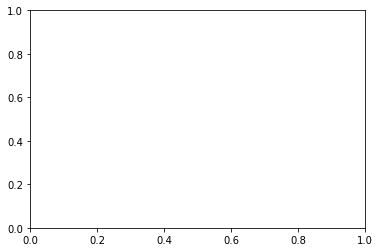

In [137]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x_ic[:,0],x_ic[:,1])
ax.scatter(x_int[:,0],x_int[:,1])
ax.scatter(x_bc[:,0],x_bc[:,1])
#ax.set_ylim(0.0, 1.2)
plt.show()

In [138]:
y = self.net(x)                                                
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]

yR = self.net(xR)                                                
rhoR,pR,uR = yR[:, 0:1], yR[:, 1:2], yR[:, 2:]
yL = self.net(xL)                                                
rhoL,pL,uL = yL[:, 0:1], yL[:, 1:2], yL[:, 2:]


    #((rho_t).mean())**2 +\
            #((U3_t).mean())**2 

NameError: name 'self' is not defined

In [139]:
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
loss_history=[]
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.05:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')


epoch 1 loss_pde:0.00053565,loss_rh1:0.00000000,loss_con:0.50209262, loss_s:0.00000000, loss_ic:4.84562957
loss_tot:117.06915573
epoch 2 loss_pde:0.00048310,loss_rh1:0.00000000,loss_con:0.50178103, loss_s:0.00000000, loss_ic:4.78816754
loss_tot:115.85850379
epoch 3 loss_pde:0.00045768,loss_rh1:0.00000000,loss_con:0.50146219, loss_s:0.00000000, loss_ic:4.73224108
loss_tot:114.68028573
epoch 4 loss_pde:0.00045176,loss_rh1:0.00000000,loss_con:0.50114158, loss_s:0.00000000, loss_ic:4.67756960
loss_tot:113.52804405
epoch 5 loss_pde:0.00046402,loss_rh1:0.00000000,loss_con:0.50081774, loss_s:0.00000000, loss_ic:4.62390034
loss_tot:112.39570865
epoch 6 loss_pde:0.00049159,loss_rh1:0.00000000,loss_con:0.50048812, loss_s:0.00000000, loss_ic:4.57097030
loss_tot:111.27699392
epoch 7 loss_pde:0.00053019,loss_rh1:0.00000000,loss_con:0.50015355, loss_s:0.00000000, loss_ic:4.51852050
loss_tot:110.16588113
epoch 8 loss_pde:0.00057472,loss_rh1:0.00000000,loss_con:0.49981603, loss_s:0.00000000, loss_ic:4

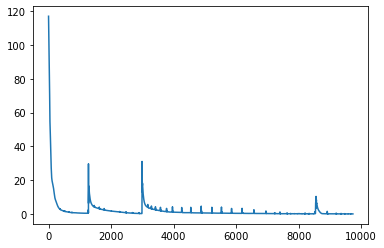

In [130]:
plt.plot(loss_history)

In [143]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=30)
epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    #if loss < 0.01:
    #    break
toc = time.time()

print(f'Total training time: {toc - tic}')

epoch 9734 loss_pde:0.02854365,loss_rh1:0.00000000,loss_con:0.00003136, loss_s:0.00000000, loss_ic:0.00197940
epoch 9734 loss_pde:0.05015897,loss_rh1:0.00000000,loss_con:0.00002522, loss_s:0.00000000, loss_ic:0.00200054
epoch 9734 loss_pde:0.04972925,loss_rh1:0.00000000,loss_con:0.00002527, loss_s:0.00000000, loss_ic:0.00200033
epoch 9734 loss_pde:0.04930355,loss_rh1:0.00000000,loss_con:0.00002533, loss_s:0.00000000, loss_ic:0.00200011
epoch 9734 loss_pde:0.04888632,loss_rh1:0.00000000,loss_con:0.00002538, loss_s:0.00000000, loss_ic:0.00199988
epoch 9734 loss_pde:0.04847744,loss_rh1:0.00000000,loss_con:0.00002543, loss_s:0.00000000, loss_ic:0.00199965
epoch 9734 loss_pde:0.04807674,loss_rh1:0.00000000,loss_con:0.00002549, loss_s:0.00000000, loss_ic:0.00199941
epoch 9734 loss_pde:0.04768408,loss_rh1:0.00000000,loss_con:0.00002554, loss_s:0.00000000, loss_ic:0.00199917
epoch 9734 loss_pde:0.04729931,loss_rh1:0.00000000,loss_con:0.00002559, loss_s:0.00000000, loss_ic:0.00199892
epoch 9734

In [140]:
x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(Te,  Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_1,xL,xR,xP,xPL,xPR = X_entropy(x_test,0.00,0.01,0.01)
x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(device)
xR = torch.tensor(xR, dtype=dtype).to(device)
xL = torch.tensor(xL, dtype=dtype).to(device)
u_pred = model(x_test)
uL_pred = model(xL)
uR_pred = model(xR)
rho, p,u = u_pred[:, 0], u_pred[:, 1], u_pred[:, 2]          
rhoL, pL,uL = uL_pred[:, 0], uL_pred[:, 1], uL_pred[:, 2]          
rhoR, pR,uR = uR_pred[:, 0], uR_pred[:, 1], uR_pred[:, 2]          
U2 = rho*u
U3 = 0.5*rho*u**2 + p/0.4

#F1 = U2
F2 = rho*u**2+p
F3 = u*(U3 + p)

gamma = 1.4                                                    

# Gradients and partial derivatives
drho_g = gradients(rho, x_test)[0]                                  
rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


du_g = gradients(u, x_test)[0]                                      
u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                      
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                     
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           

dU2_g = gradients(U2, x_test)[0]
U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
dU3_g = gradients(U3, x_test)[0]
U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
dF2_g = gradients(F2, x_test)[0]
F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
dF3_g = gradients(F3, x_test)[0]
F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

d = 0.1*(abs(u_x)-(u_x))  + 1

#d = 0.1*(abs(uR-uL)-(uR-uL))/Dx + 1
#d = torch.exp(-10*u_x)+1
#d1 = torch.clamp(d/5,min=1)

f = ((rho_t + U2_x)/d)**2 + \
    ((U2_t  + F2_x)/d)**2 + \
    ((U3_t  + F3_x)/d)**2 #+\
#d = 1/(0.1*(torch.clamp((abs(u_x)-u_x))
d = 1/(0.1*(abs(u_x)-u_x)+1)
d2 =1/(0.1*(abs(uR-uL)-(uR-uL))/0.02  + 1)
d = to_numpy(d)
d2 = to_numpy(d2)
f = to_numpy(f)
#d3 = to_numpy(d3)
u_pred = to_numpy(u_pred)
np.size(u_pred[:,0])

100

In [141]:
Te

0.1

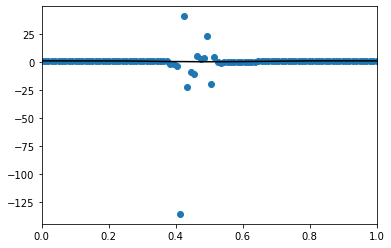

In [142]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#ax.scatter(x[:],u_pred[:,0])
#ax.scatter(x[:],u_pred[:,1])
#ax.scatter(x[:],u_pred[:,2])
ax.scatter(x[:],u_pred[:,1]*pref/u_pred[:,0]/rhoref/0.4)
#ax.scatter(x[:],d)
#ax.scatter(x[:],f)
#ax.plot(Exact[:,0],Exact[:,1],color='black')
#ax.plot(Exact[:,0],Exact[:,2],color='black')
#ax.plot(Exact[:,0],Exact[:,3],color='black')
ax.plot(Exact[:,0],Exact[:,4]/0.4,color='black')
ax.set_xlim(0.0, 1.0)
plt.savefig('1.eps', format='eps')
#ax.set_ylim(0.0, 1.2)
plt.show()

In [ ]:
u_pred_i[:,:,k] = u_pred
k = k+1

In [295]:

u_pred_i = np.zeros((100,3,10))
k = 0

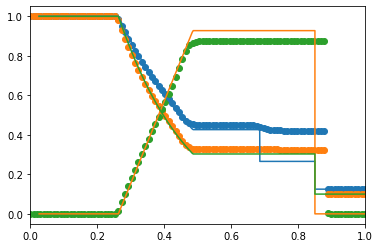

In [154]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
ax.plot(Exact[:,0],Exact[:,1])
ax.plot(Exact[:,0],Exact[:,2])
ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [42]:
Exact = np.loadtxt('123e.dat')
Exact[:,0]

array([-0.0496663 , -0.04829213, -0.04691796, ...,  1.0455438 ,
        1.04691796,  1.04829213])

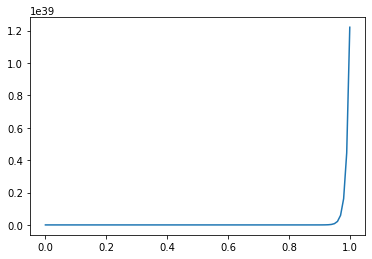

In [346]:
fig,ax = plt.subplots()
x = np.linspace(0,1,100)
#ax.plot(x,np.max([0.1-x,np.zeros_like(x)],axis=0))
#ax.plot(x,np.exp(100*(0.1-x))/ np.exp(100*(0.1)))
#ax.plot(x,np.exp(100*(-x)))
ax.plot(x,np.exp(100*(x-0.1)))
plt.show()

In [322]:
np.max([0.1-x,np.zeros_like(x)],axis=0)

array([0.1       , 0.08989899, 0.07979798, 0.06969697, 0.05959596,
       0.04949495, 0.03939394, 0.02929293, 0.01919192, 0.00909091,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [60]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

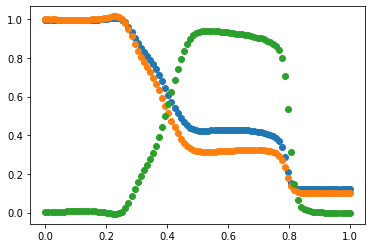

In [266]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

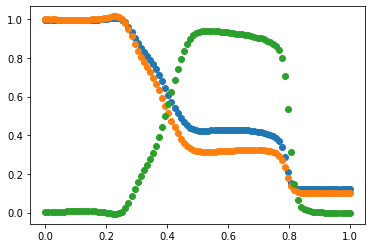

In [267]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()